In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw
from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

from eofs.standard import Eof

from dateutil        import parser
from datetime import datetime

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]

# tmask = mask.variables['tmask'][0,:32,220:280, 590:650]
# umask = mask.variables['umask'][0,:32,220:280, 590:650]
# vmask = mask.variables['vmask'][0,:32,220:280, 590:650]
# mbathy = mask.variables['mbathy'][0,220:280, 590:650]


# y_wcvi_slice = np.array(np.arange(220,280))
# x_wcvi_slice = np.array(np.arange(590,650))
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# mbathy[mbathy>32] = 32

In [3]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [4]:
iso_spic.shape

(180, 7, 170, 170)

In [71]:
signal_spic = iso_spic[:,4,...]

In [72]:
solver = Eof(signal_spic)

pcs = solver.pcs(npcs=5,pcscaling=1)

In [73]:
pcs.shape

(180, 5)

In [74]:
eofs = solver.eofsAsCorrelation(neofs=5)

In [11]:
eofs.shape

(5, 170, 170)

In [4]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [5]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    

In [6]:
isot[4]

26.4

In [20]:

t1 =112
t2 = 123

u_falk = u_vel[t1:t2, ...]
u_mean = np.mean(u_falk, axis=0)
v_falk = v_vel[t1:t2, ...]
v_mean = np.mean(v_falk, axis=0)

rho_falk = rho[t1:t2,...]
rho_mean = np.mean(rho_falk, axis=0)




rho_0 = 26.4

u_rho_0 = np.zeros_like(iso_spic[0,0,...])
v_rho_0 = np.zeros_like(u_rho_0)

# u_tzyx = np.empty((u_vel.shape[0],zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_tzyx = np.empty_like(u_tzyx)

# for t in np.arange(u_tzyx.shape[0]):

for level in np.arange(zlevels.shape[0]):
    u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])
# rho[t,...] = np.ma.masked_array(rho[t,...], mask= 1- tmask[...])



for j in np.arange(rho.shape[2]):
    for i in np.arange(rho.shape[3]):
        if mbathy[j,i] > 0:
#             u_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, u_vel[t,:mbathy[j, i], j, i])
#             v_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, v_vel[t,:mbathy[j, i], j, i])
            u_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, u_tzyx[:mbathy[j, i], j, i])
            v_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, v_tzyx[:mbathy[j, i], j, i])


# k = np.where(short_iso_t[:] == rho_0)

# spic_tzyx = short_spic_iso_jun[t,k[0],...]
# spic_tzyx[np.isnan(spic_tzyx)] = 0
# spic_iso = np.ma.masked_equal(spic_tzyx[0,...], 0)

In [21]:
iso_spic.shape

(180, 7, 170, 170)

In [6]:
def plot_iso_spice_currents(t1,t2,iso_level):  
    
    arrow_step = 5
    
    y_wcvi_slice = np.array(np.arange(180,350))
    x_wcvi_slice = np.array(np.arange(480,650))
    
    u_falk = u_vel[t1:t2, ...]
    u_mean = np.mean(u_falk, axis=0)
    v_falk = v_vel[t1:t2, ...]
    v_mean = np.mean(v_falk, axis=0)

    rho_falk = rho[t1:t2,...]
    rho_mean = np.mean(rho_falk, axis=0)




    rho_0 = isot[iso_level]

    u_rho_0 = np.zeros_like(iso_spic[0,0,...])
    v_rho_0 = np.zeros_like(u_rho_0)


    u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
    v_tzyx = np.empty_like(u_tzyx)



    for level in np.arange(zlevels.shape[0]):
        u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])




    for j in np.arange(rho.shape[2]):
        for i in np.arange(rho.shape[3]):
            if mbathy[j,i] > 0:
                u_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, u_tzyx[:mbathy[j, i], j, i])
                v_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, v_tzyx[:mbathy[j, i], j, i])





    val_iso = iso_spic[t1:t2,iso_level,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)
    val_iso = np.mean(val_iso, axis=0)


    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')

    fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin=-0.1, vmax=0)
    cbar = fig.colorbar(q, ax=ax)
    

    speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('Spice (26.4 isopycnal) with currents at same isopycnal ')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


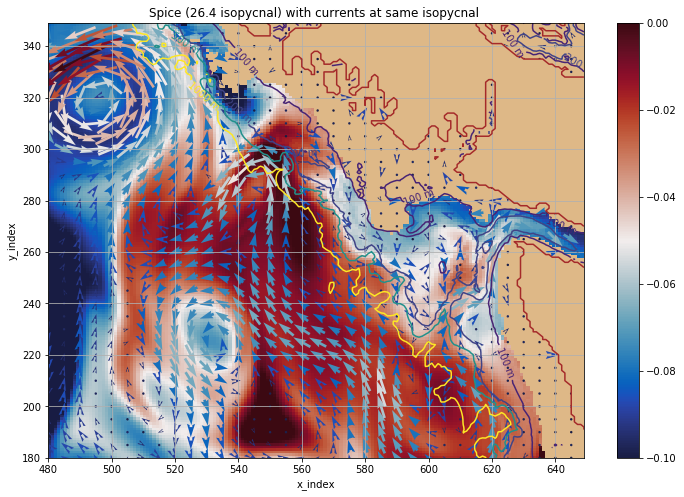

In [7]:
plot_iso_spice_currents(t1=112, t2=123, iso_level=4)

In [ ]:


arrow_step = 5

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

u_falk = u_vel[t1:t2, ...]
u_mean = np.mean(u_falk, axis=0)
v_falk = v_vel[t1:t2, ...]
v_mean = np.mean(v_falk, axis=0)

rho_falk = rho[t1:t2,...]
rho_mean = np.mean(rho_falk, axis=0)




rho_0 = isot[iso_level]

u_rho_0 = np.zeros_like(iso_spic[0,0,...])
v_rho_0 = np.zeros_like(u_rho_0)


u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_tzyx = np.empty_like(u_tzyx)



for level in np.arange(zlevels.shape[0]):
    u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])




for j in np.arange(rho.shape[2]):
    for i in np.arange(rho.shape[3]):
        if mbathy[j,i] > 0:
            u_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, u_tzyx[:mbathy[j, i], j, i])
            v_rho_0[j, i] = np.interp(rho_0, rho_mean[:mbathy[j, i], j, i]-1000, v_tzyx[:mbathy[j, i], j, i])





val_iso = iso_spic[t1:t2,iso_level,...]
val_iso[np.isnan(val_iso)] = 0
val_iso = np.ma.masked_equal(val_iso, value=0)
val_iso = np.mean(val_iso, axis=0)



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][180:350, 480:650]
lat = bathy['nav_lat'][180:350, 480:650]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('burlywood')

fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin=-0.1, vmax=0)
cbar = fig.colorbar(q, ax=ax)


speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('Spice (26.4 isopycnal) with currents at same isopycnal ')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
ax.grid()


In [54]:
v_falk = v_vel[t1:t2,:, :121, 80:]
v_mean = np.mean(v_falk, axis=0)

In [62]:
v_mean.shape

(32, 121, 91)

In [23]:
zlevels[24]

155.85072

In [7]:
def plot_iso_spice_currents_shorter(t1,t2,iso_level):  
    
    arrow_step = 3
    
    y_wcvi_slice = np.array(np.arange(180,300))
    x_wcvi_slice = np.array(np.arange(560,650))
    
    u_falk = u_vel[t1:t2,:,:121, 80:]
    u_mean = np.mean(u_falk, axis=0)
    v_falk = v_vel[t1:t2,:, :121, 80:]
    v_mean = np.mean(v_falk, axis=0)

    rho_falk = rho[t1:t2,:,:121, 80:]
    rho_mean = np.mean(rho_falk, axis=0)




    rho_0 = isot[iso_level]
    
    iso_short = iso_spic[:,:,:120, 80:]

    u_rho_0 = np.zeros_like(iso_short[0,0,...])
    v_rho_0 = np.zeros_like(u_rho_0)


    u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
    v_tzyx = np.empty_like(u_tzyx)



    for level in np.arange(zlevels.shape[0]):
        u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])




    for j in np.arange(u_tzyx.shape[1]):
        for i in np.arange(u_tzyx.shape[2]):
#             if mbathy[j,i] > 0:
            u_rho_0[j, i] = np.interp(rho_0, rho_mean[:24, j, i]-1000, u_tzyx[:24, j, i])
            v_rho_0[j, i] = np.interp(rho_0, rho_mean[:24, j, i]-1000, v_tzyx[:24, j, i])





    val_iso = iso_short[t1:t2,iso_level,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)
    val_iso = np.mean(val_iso, axis=0)


    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')

    fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin=-0.1, vmax=0)
    cbar = fig.colorbar(q, ax=ax)
    

    speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('Spice (26.4 isopycnal) with currents at same isopycnal ')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


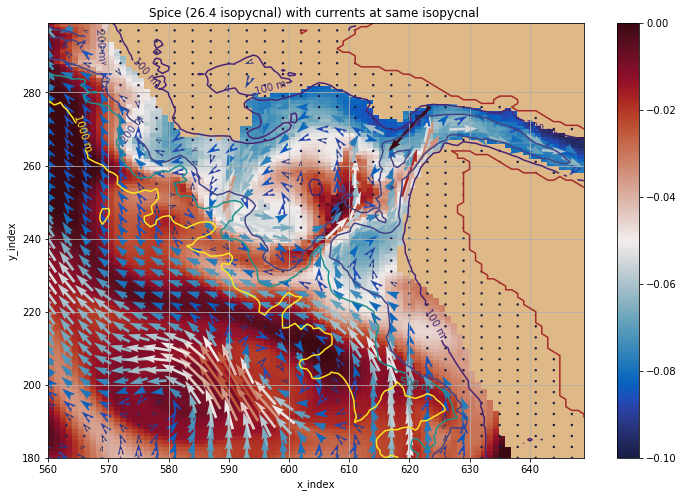

In [8]:
plot_iso_spice_currents_shorter(t1=111, t2=112, iso_level=4)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


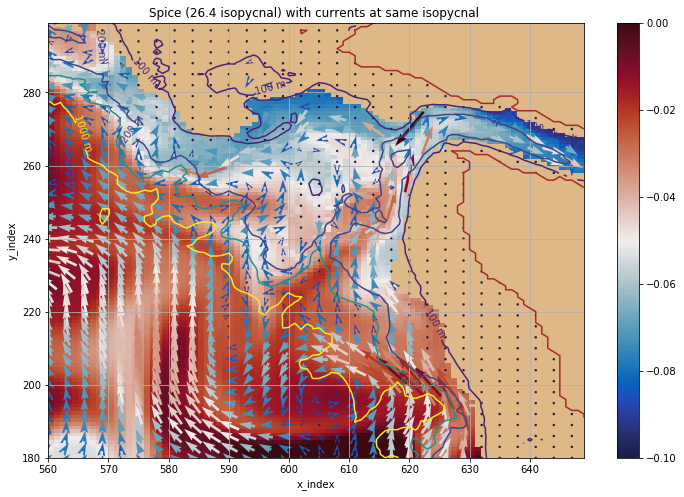

In [32]:
plot_iso_spice_currents_shorter(t1=123, t2=124, iso_level=4)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


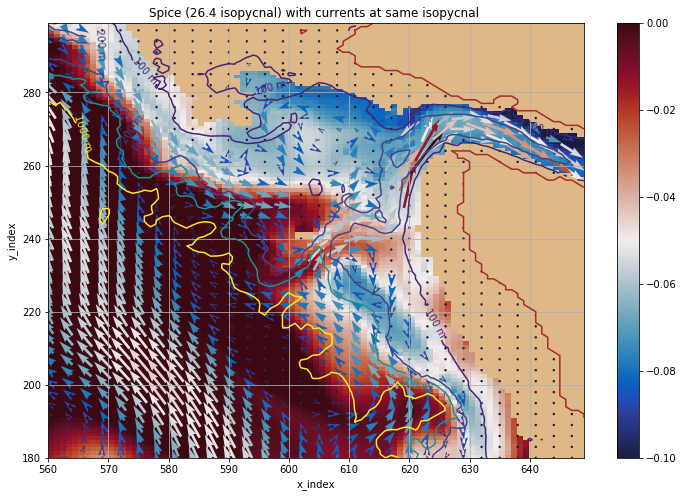

In [20]:
plot_iso_spice_currents_shorter(t1 = 90, t2=95, iso_level=4)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


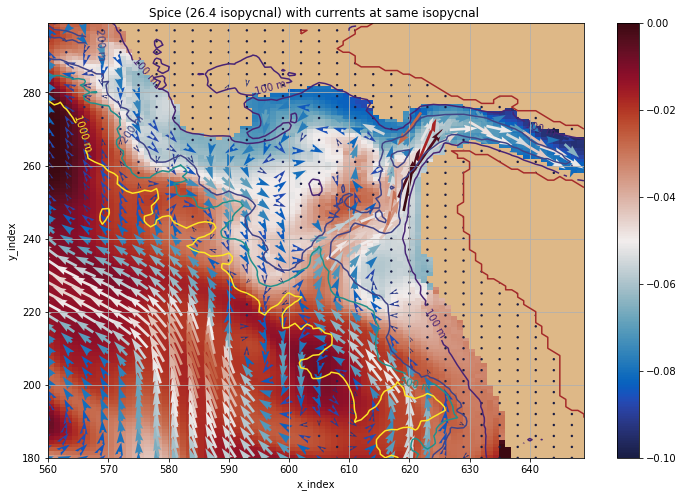

In [27]:
plot_iso_spice_currents_shorter(t1=112, t2=123, iso_level=4)

In [64]:
def plot_isopycnal_spice(level_of_currents, t1, t2, iso_level):
    

    val_iso = iso_spic[t1:t2,iso_level,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)
    val_iso = np.mean(val_iso, axis=0)




    u_week = u_vel[t1:t2,level_of_currents,:,:]
    v_week = v_vel[t1:t2,level_of_currents,:,:]


    u_mean = np.mean(u_week, axis=0)
    v_mean = np.mean(v_week, axis=0)
    arrow_step = 5




    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']

    y_wcvi_slice = np.array(np.arange(180,350))
    x_wcvi_slice = np.array(np.arange(480,650))


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]


    # cmap = plt.get_cmap('Blues')
    cmap = plt.get_cmap(cmo.cm.balance)


    cmap.set_bad('burlywood')
    fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
    # p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=1000)
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
#     CS = ax.contour(x_wcvi_slice,y_wcvi_slice,depth_rho_0, levels =[0, 100, 200, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin=-0.1, vmax=0)
    cbar = fig.colorbar(q, ax=ax)

    u_tzyx, v_tzyx = viz_tools.unstagger(u_mean[...], v_mean[...])
    u_tzyx = np.ma.masked_array(u_tzyx, mask= 1- umask[level_of_currents,1:,1:,])
    v_tzyx = np.ma.masked_array(v_tzyx, mask= 1- vmask[level_of_currents,1:,1:])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[::arrow_step,::arrow_step], v_tzyx[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)


    # ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.6, label = 'Closest Falkor Points')
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('Spice (26.4 isopycnal) with currents at {d:.2f}m '.format(d = zlevels[level_of_currents]), fontsize=20)

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    # cbar = fig.colorbar(p, ax=ax)
    # cbar.ax.set_ylabel('Depth [m]', fontsize=20)
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


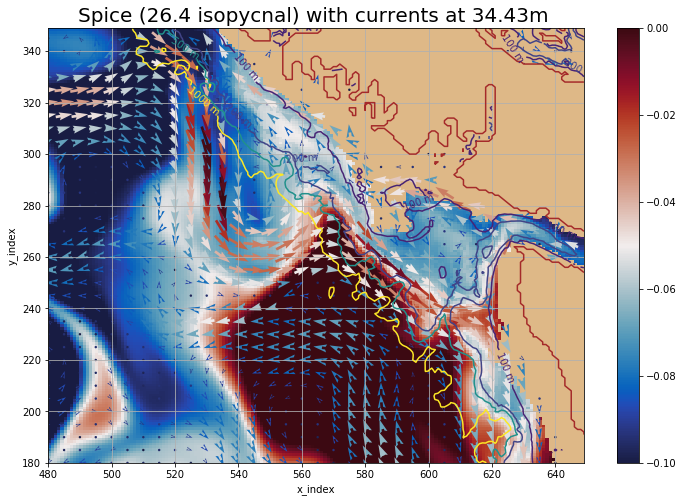

In [121]:
plot_isopycnal_spice(iso_level=4, level_of_currents=15, t1= 75,t2=85)

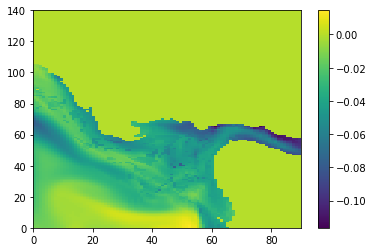

In [75]:
plt.pcolormesh(iso_spic[7,4,30:, 80:])
plt.colorbar()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


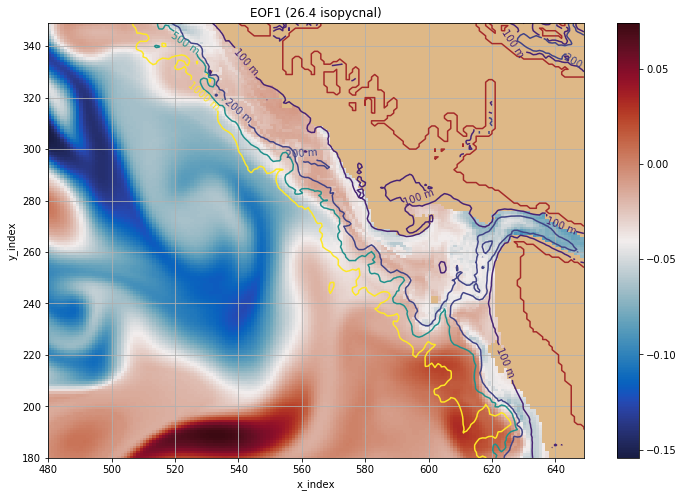

In [51]:
eddy_at_iso_level_time(0,4)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


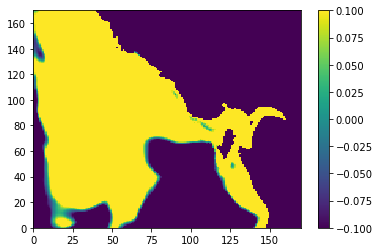

In [80]:
plt.pcolormesh(eofs[0,...])
plt.colorbar()

In [12]:
def plot_isopycnal_eof_spice(eof_number):
    

    val_iso = eofs[eof_number,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)








    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']

#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(590,650))


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]


    # cmap = plt.get_cmap('Blues')
    cmap = plt.get_cmap(cmo.cm.balance)


    cmap.set_bad('burlywood')
    fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
    # p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=1000)
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
#     CS = ax.contour(x_wcvi_slice,y_wcvi_slice,depth_rho_0, levels =[0, 100, 200, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmax = -1, vmin = 1)
    cbar = fig.colorbar(q, ax=ax)


    # ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.6, label = 'Closest Falkor Points')
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('EOF1 (26.4 isopycnal)')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    # cbar = fig.colorbar(p, ax=ax)
    # cbar.ax.set_ylabel('Depth [m]', fontsize=20)
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


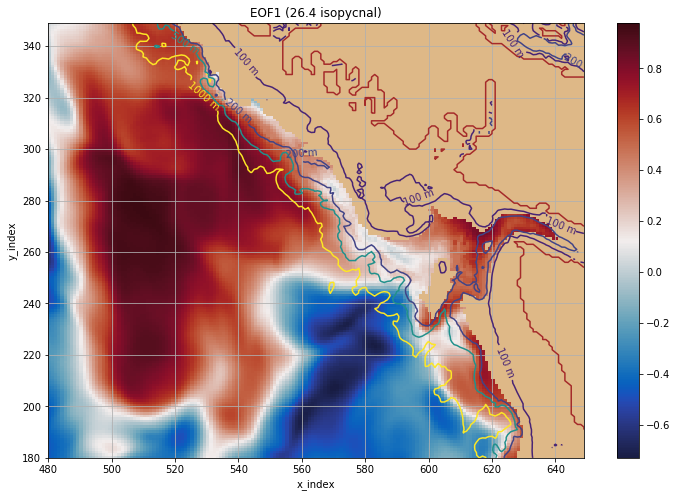

In [13]:
plot_isopycnal_eof_spice(0)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


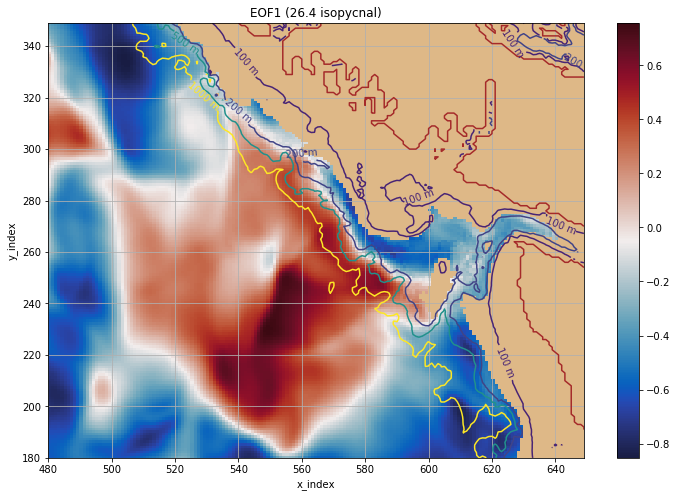

In [14]:
plot_isopycnal_eof_spice(1)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


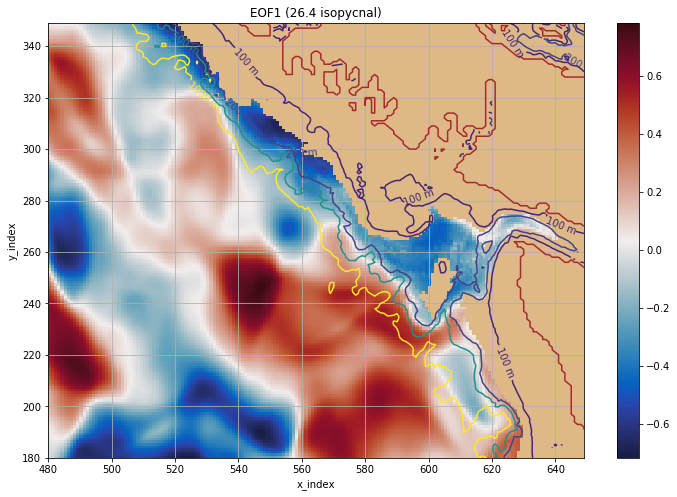

In [15]:
plot_isopycnal_eof_spice(2)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


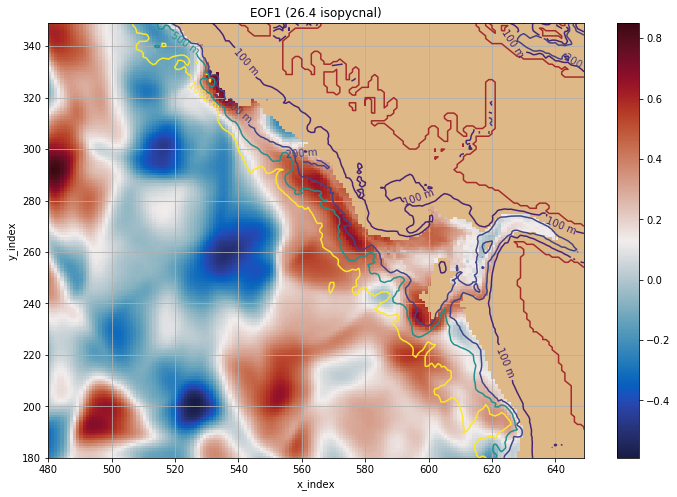

In [67]:
plot_isopycnal_eof_spice(3)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


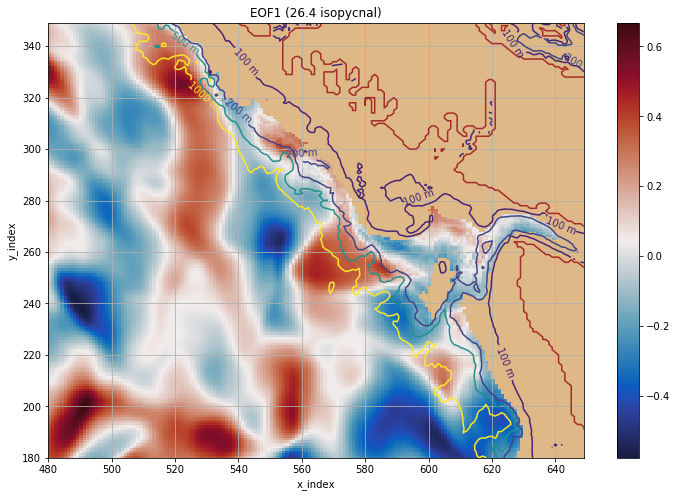

In [68]:
plot_isopycnal_eof_spice(4)

1) What does scaled to unit variance mean ? Also what does the magnitude in the colorbar indicate for the individual EOFs ?

2) when does the eddy form and it intensifies ? (see from literature)

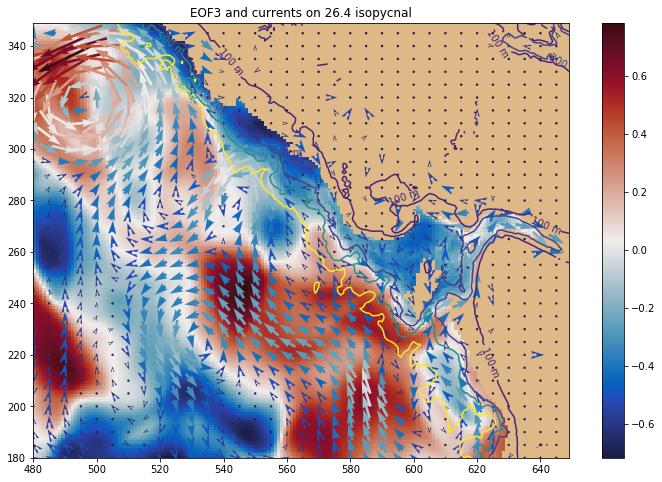

In [43]:
arrow_step = 5

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][180:350, 480:650]
lat = bathy['nav_lat'][180:350, 480:650]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('burlywood')

val_iso = eofs[2,...]
val_iso[np.isnan(val_iso)] = 0
val_iso = np.ma.masked_equal(val_iso, value=0)

fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()

CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmin=-0.1, vmax=0)
cbar = fig.colorbar(q, ax=ax)


speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)

ax.set_title("EOF3 and currents on 26.4 isopycnal")

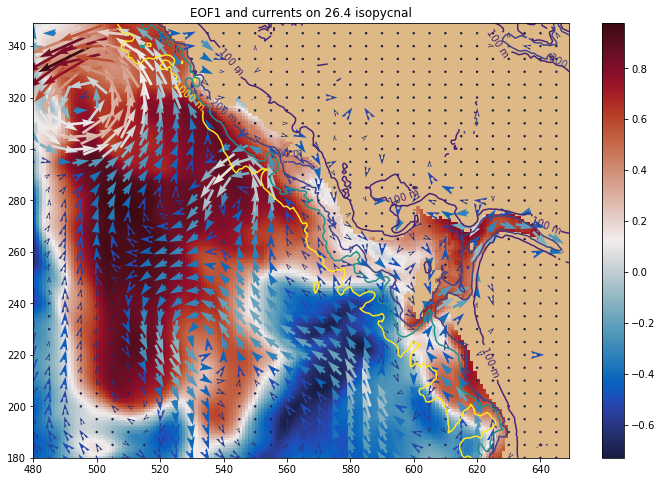

In [44]:
arrow_step = 5

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][180:350, 480:650]
lat = bathy['nav_lat'][180:350, 480:650]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('burlywood')

val_iso = eofs[0,...]
val_iso[np.isnan(val_iso)] = 0
val_iso = np.ma.masked_equal(val_iso, value=0)

fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()

CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmin=-0.1, vmax=0)
cbar = fig.colorbar(q, ax=ax)


speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)

ax.set_title("EOF1 and currents on 26.4 isopycnal")

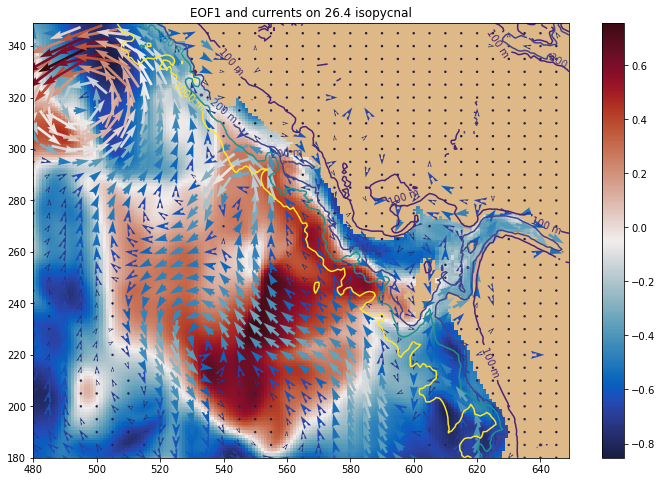

In [45]:
arrow_step = 5

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][180:350, 480:650]
lat = bathy['nav_lat'][180:350, 480:650]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('burlywood')

val_iso = eofs[1,...]
val_iso[np.isnan(val_iso)] = 0
val_iso = np.ma.masked_equal(val_iso, value=0)

fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()

CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmin=-0.1, vmax=0)
cbar = fig.colorbar(q, ax=ax)


speeds = np.sqrt(np.square(u_rho_0) + np.square(v_rho_0))
quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005, minshaft= 0.5)

ax.set_title("EOF1 and currents on 26.4 isopycnal")

In [75]:


eigenValues = solver.eigenvalues()

anomaly_var = solver.totalAnomalyVariance()

percentContrib = eigenValues*100./np.sum(eigenValues)

In [43]:
anomaly_var

14.068445

In [44]:
np.sum(percentContrib[:5])

78.392876

In [45]:
pcs[:,1]

array([-2.54655981, -2.54856491, -2.52888155, -2.52720904, -2.4985671 ,
       -2.49030042, -2.46610403, -2.45674539, -2.41750383, -2.39995456,
       -2.37203956, -2.35740638, -2.3203578 , -2.25753474, -2.17106795,
       -2.05489898, -1.93936312, -1.80033088, -1.7026993 , -1.61193419,
       -1.54580379, -1.48986387, -1.44276679, -1.39317179, -1.33390462,
       -1.25342715, -1.17496812, -1.10799956, -1.04445148, -0.99073017,
       -0.93543762, -0.89437205, -0.85899407, -0.79664463, -0.73737824,
       -0.66030365, -0.5916993 , -0.51173198, -0.44485855, -0.39052054,
       -0.32430273, -0.25796992, -0.19329576, -0.1427948 , -0.09369604,
       -0.0568956 , -0.01931085,  0.01666743,  0.06592306,  0.10989277,
        0.16774376,  0.20964178,  0.26137331,  0.30906671,  0.35724303,
        0.39836037,  0.44603109,  0.48061007,  0.51087397,  0.53805   ,
        0.55111521,  0.56596249,  0.56072986,  0.55478245,  0.53966552,
        0.52584863,  0.51815444,  0.51960105,  0.53735691,  0.59

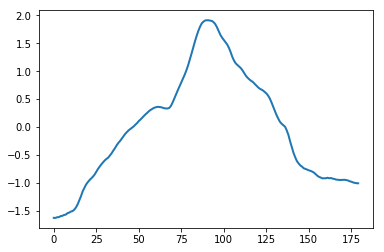

In [193]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,1]


plt.plot(x, y, linewidth=2.0)

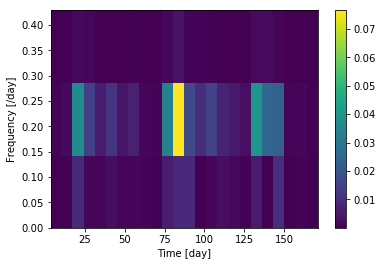

In [195]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [/day]')
plt.xlabel('Time [day]')
plt.colorbar()
plt.show()

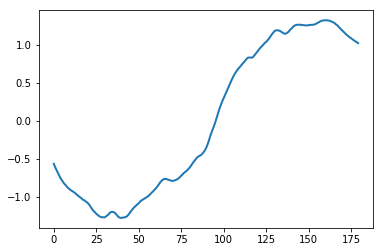

In [184]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,0]


plt.plot(x, y, linewidth=2.0)

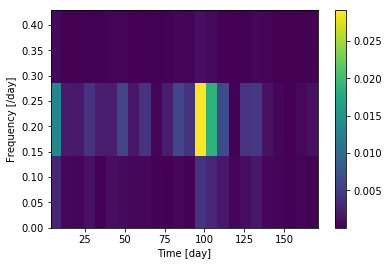

In [189]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [/day]')
plt.xlabel('Time [day]')
plt.colorbar()
plt.show()

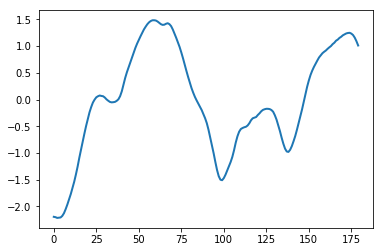

In [196]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,2]


plt.plot(x, y, linewidth=2.0)

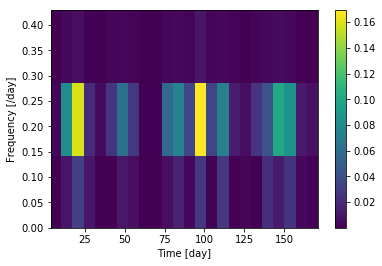

In [198]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [/day]')
plt.xlabel('Time [day]')
plt.colorbar()
plt.show()

In [206]:
sp = np.fft.fft(y)

In [212]:
np.min(sp.real)

-33.959830386006146

In [213]:
absp = np.absolute(sp.real)

In [217]:
np.max(absp)

33.959830386006146

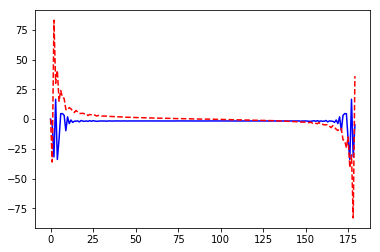

In [218]:
plt.plot(x, sp.real, 'b-', x, sp.imag, 'r--')

In [219]:
s = np.fft.ifft(y)

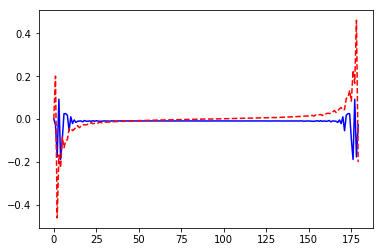

In [220]:
plt.plot(x, s.real, 'b-', x, s.imag, 'r--')

In [97]:
fs = 10e3

In [33]:
from scipy.signal import spectrogram, get_window, correlate

In [185]:
p = get_window('hanning', 7, fftbins=True)

In [186]:
p.shape

(7,)

In [187]:
x.shape

(180,)

In [197]:
f, t, Sxx = spectrogram(y, window = p)

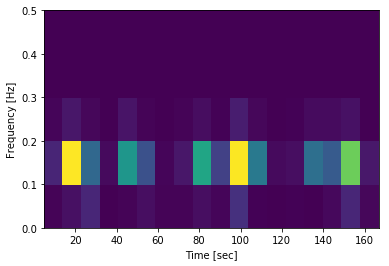

3) Check with a hovmoller (depth vs time) if the 3rd EOF (which dilenates the eddy structure) shows similar trend with time 

4) Analyse the spice signals at different times of the upward and downward curves from the last time series plot of 3rd EOF and see how the complete spice signal looked like ?

5) Plot the winds on those dates as well 

6) We need to find the frequency of each of the EOFS and see which ones are seasonal and which are episodic (the PC corresponding to the EOF having most of the zero crossings may be associated with the entrainment of water into the eddy (that can be the leaky front signal) see the paper portion before the summary https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/JC093iC06p06863



7) Multivariate EOF with winds and spice at the same isopycnal



In [140]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 520:630]
umask = mask.variables['umask'][0,:32,180:350, 520:630]
vmask = mask.variables['vmask'][0,:32,180:350, 520:630]
mbathy = mask.variables['mbathy'][0,180:350, 520:630]

# tmask = mask.variables['tmask'][0,:32,220:280, 590:650]
# umask = mask.variables['umask'][0,:32,220:280, 590:650]
# vmask = mask.variables['vmask'][0,:32,220:280, 590:650]
# mbathy = mask.variables['mbathy'][0,220:280, 590:650]


# y_wcvi_slice = np.array(np.arange(220,280))
# x_wcvi_slice = np.array(np.arange(590,650))
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(520,630))


# mbathy[mbathy>32] = 32

In [141]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...][:,:,:,40:150]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [142]:
signal_spic = iso_spic[:,4,...]

solver = Eof(signal_spic)

pcs = solver.pcs(npcs=5,pcscaling=1)

eofs = solver.eofsAsCorrelation(neofs=5)

In [28]:
def plot_isopycnal_eof_spice(eof_number):
    

    val_iso = eofs[eof_number,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)








    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']

#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(590,650))


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]


    # cmap = plt.get_cmap('Blues')
    cmap = plt.get_cmap(cmo.cm.balance)


    cmap.set_bad('burlywood')
    fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()
    # p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=1000)
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
#     CS = ax.contour(x_wcvi_slice,y_wcvi_slice,depth_rho_0, levels =[0, 100, 200, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmax = -1, vmin = 1)
    cbar = fig.colorbar(q, ax=ax)


    # ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.6, label = 'Closest Falkor Points')
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('EOF1 (26.4 isopycnal)')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    # cbar = fig.colorbar(p, ax=ax)
    # cbar.ax.set_ylabel('Depth [m]', fontsize=20)
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


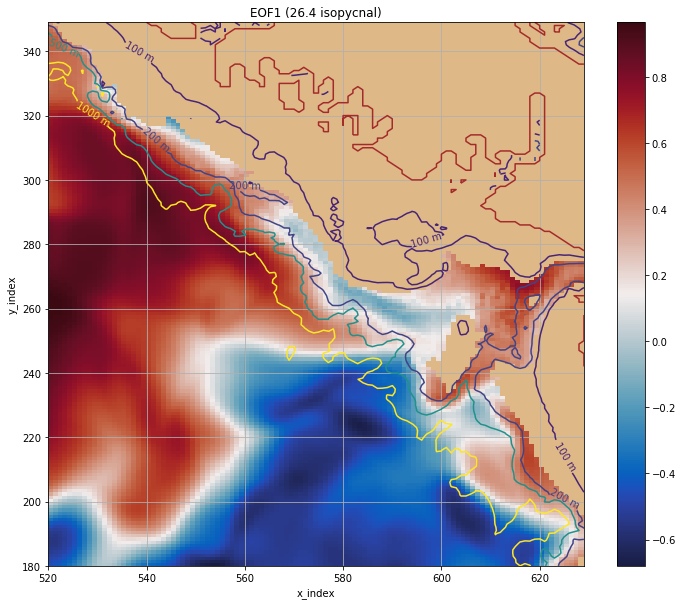

In [29]:
plot_isopycnal_eof_spice(0)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


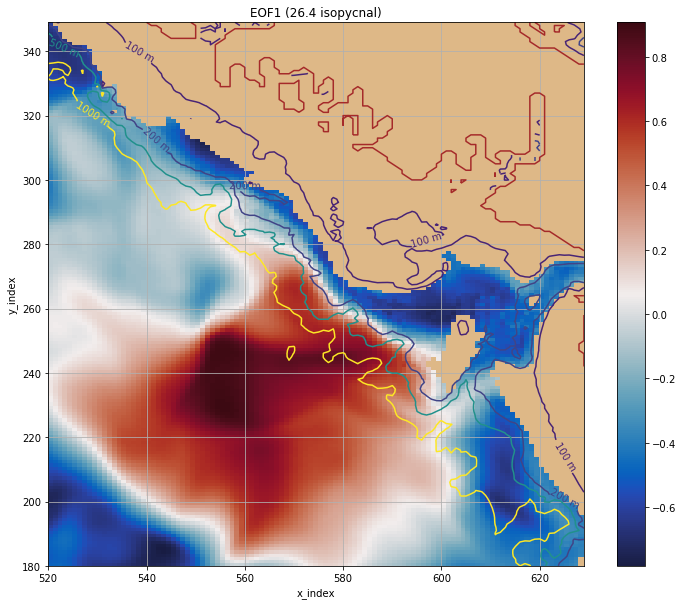

In [30]:
plot_isopycnal_eof_spice(1)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


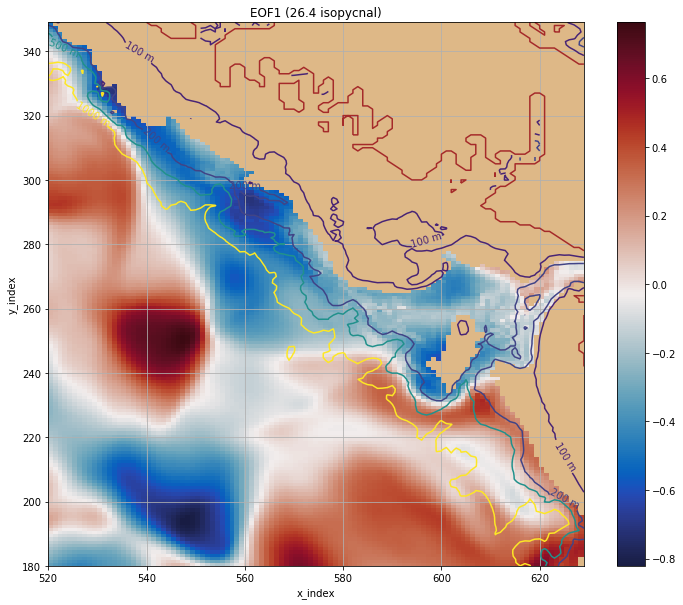

In [31]:
plot_isopycnal_eof_spice(2)

In [143]:


eigenValues = solver.eigenvalues()

anomaly_var = solver.totalAnomalyVariance()

percentContrib = eigenValues*100./np.sum(eigenValues)

In [54]:
percentContrib[2]

11.610019

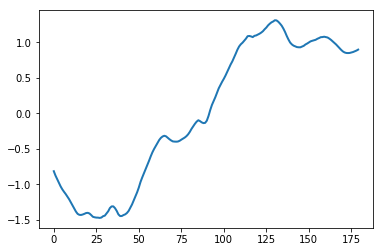

In [55]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,0]


plt.plot(x, y, linewidth=2.0)

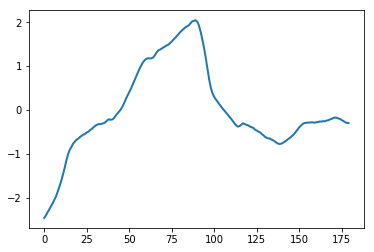

In [56]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,1]


plt.plot(x, y, linewidth=2.0)

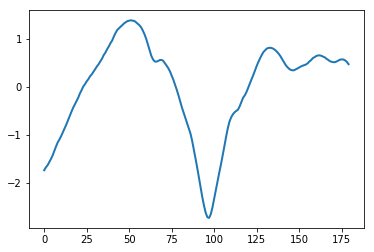

In [57]:
x = np.arange(pcs[:,1].shape[0])
y = pcs[:,2]


plt.plot(x, y, linewidth=2.0)

In [24]:
date1 = '2013-04-29'
date2 = '2013-10-25'
mydates = np.array(pd.date_range(date1, date2))


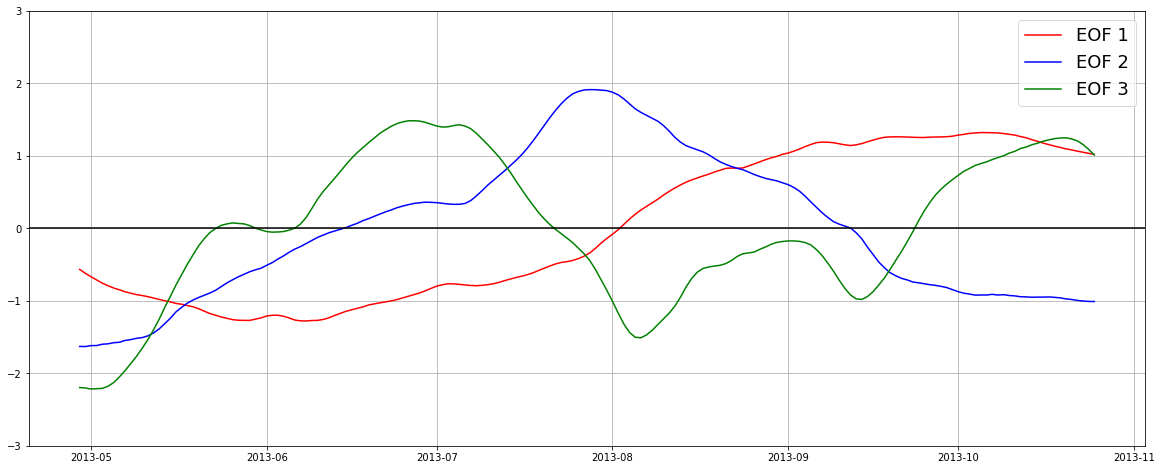

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

ax.plot(mydates,pcs[:,0] , 'r-', label = 'EOF 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'EOF 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'EOF 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 

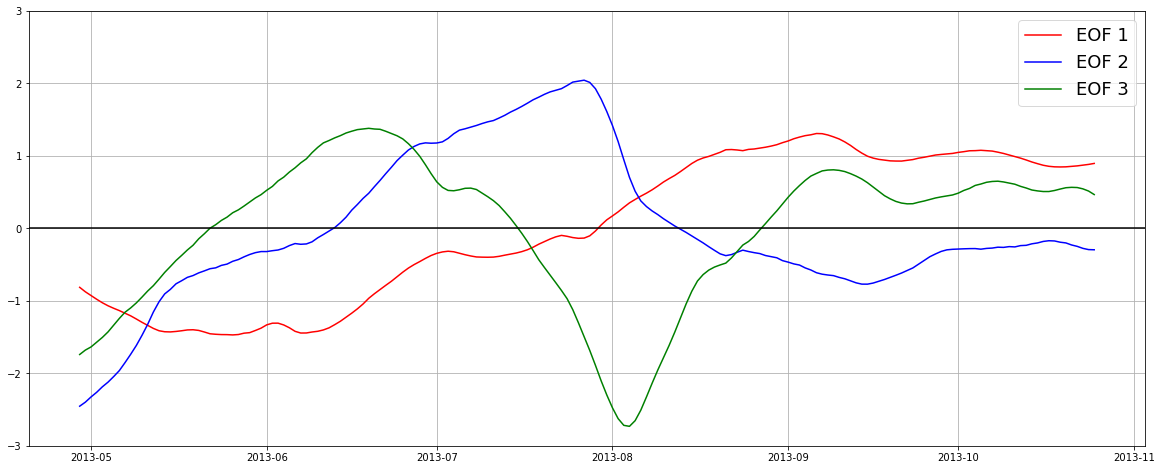

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))


ax.plot(mydates,pcs[:,0] , 'r-', label = 'EOF 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'EOF 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'EOF 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 

In [20]:
La_Peruse_data = pd.read_table('/home/ssahu/saurav/LA_PERUSE_wavebuoy_data/c46206.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

STN_ID        DATE   TIME LATITUDE LONGITUDE  DEPTH  VCAR   VTPK  \
217132  C46206  06/18/2018  18:38    48.83    126.00  72.00  2.19  12.80   
217133  C46206  06/18/2018  19:38    48.83    126.00  72.00  2.04  12.80   
217134  C46206  06/19/2018  00:38    48.83    126.00  72.00  1.76  12.19   
217135  C46206  06/19/2018  04:38    48.83    126.00  72.00  1.66  12.19   
217136  C46206  06/19/2018  05:38    48.83    126.00  72.00  1.51  12.19   
217137  C46206  06/19/2018  06:38    48.83    126.00  72.00  1.59  11.13   
217138  C46206  06/19/2018  13:38    48.83    126.00  72.00  1.51  11.64   
217139  C46206  06/19/2018  17:38    48.83    126.00  72.00  1.50  11.13   
217140  C46206  06/19/2018  18:38    48.83    126.00  72.00  1.45  15.06   
217141  C46206  06/19/2018  21:38    48.83    126.00  72.00  1.47  10.67   

         VWH  VCMX    VTP    WDIR  WSPD         Date_time  
217132  2.20  6.40  12.80   58.00  3.50  06/18/2018 18:38  
217133  2.00  3.80  12.80   64.00  3.70  06/18/2018 19:38  
217134  1.80  2.60  12.20  155.00  2.60  06/19/2018 00:38  
217135  1.70  2.70  12.20   86.00  2.60  06/19/2018 04:38  
217136  1.50  2.40  12.20   65.00  3.50  06/19/2018 05:38  
217137  1.60  2.80  11.10   64.00  4.80  06/19/2018 06:38  
217138  1.40  7.10  11.60   51.00  4.60  06/19/2018 13:38  
217139  1.30  7.00  11.10   72.00  4.20  06/19/2018 17:38  
217140  1.40  5.20  15.10   84.00  3.40  06/19/2018 18:38  
217141  1.50  2.10  10.70   87.00  2.50  06/19/2018 21:38

In [21]:
LA_PERUSE_array = df_cut.as_matrix()

# # start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

# # end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2015')))[-1,0]

# # start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]
# # LA_PERUSE_array = df_cut.as_matrix()

# start_index_2015_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2015')))[0,0]

# end_index_2015_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2015')))[-1,0]

start_index_2013  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '04/29/2013')))[0,0]

end_index_2013  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '10/25/2013')))[-1,0]


In [22]:
wind_spd = LA_PERUSE_array[start_index_2013:end_index_2013,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013:end_index_2013,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013:end_index_2013,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

In [184]:
datetime_2013[-1]

numpy.datetime64('2013-10-25T22:38')

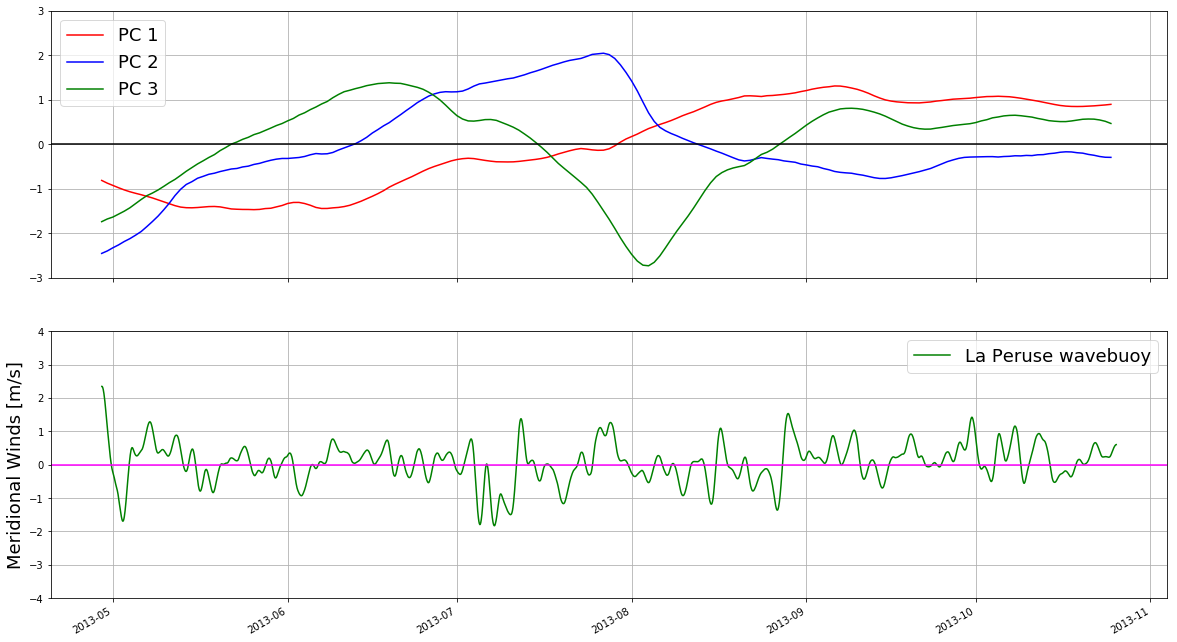

In [144]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,72,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,72,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,72,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12), sharex=True)
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



ax2.plot(time_axis, filt_v, 'g-', label = 'La Peruse wavebuoy')


# ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-4,4)
# plt.xticks(time_axis_quiver[::720], mydates[::30], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

fig.autofmt_xdate()


In [6]:
def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]



720

In [5]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,220:280, 580:630]
umask = mask.variables['umask'][0,:32,220:280, 580:630]
vmask = mask.variables['vmask'][0,:32,220:280, 580:630]
mbathy = mask.variables['mbathy'][0,220:280, 580:630]

# tmask = mask.variables['tmask'][0,:32,220:280, 590:650]
# umask = mask.variables['umask'][0,:32,220:280, 590:650]
# vmask = mask.variables['vmask'][0,:32,220:280, 590:650]
# mbathy = mask.variables['mbathy'][0,220:280, 590:650]


# y_wcvi_slice = np.array(np.arange(220,280))
# x_wcvi_slice = np.array(np.arange(590,650))
y_wcvi_slice = np.array(np.arange(220,280))
x_wcvi_slice = np.array(np.arange(580,630))


# mbathy[mbathy>32] = 32

In [7]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...][:,:,40:100,100:150]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [8]:
signal_spic = iso_spic[:,4,...]

solver = Eof(signal_spic)

pcs = solver.pcs(npcs=5,pcscaling=1)

eofs = solver.eofsAsCorrelation(neofs=5)

In [9]:
def plot_isopycnal_eof_spice(eof_number):
    

    val_iso = eofs[eof_number,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)








    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']

#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(590,650))


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]


    # cmap = plt.get_cmap('Blues')
    cmap = plt.get_cmap(cmo.cm.balance)


    cmap.set_bad('burlywood')
    fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()
    # p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=1000)
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
#     CS = ax.contour(x_wcvi_slice,y_wcvi_slice,depth_rho_0, levels =[0, 100, 200, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmax = -1, vmin = 1)
    cbar = fig.colorbar(q, ax=ax)


    # ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.6, label = 'Closest Falkor Points')
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('EOF1 (26.4 isopycnal)')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    # cbar = fig.colorbar(p, ax=ax)
    # cbar.ax.set_ylabel('Depth [m]', fontsize=20)
    ax.grid()


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


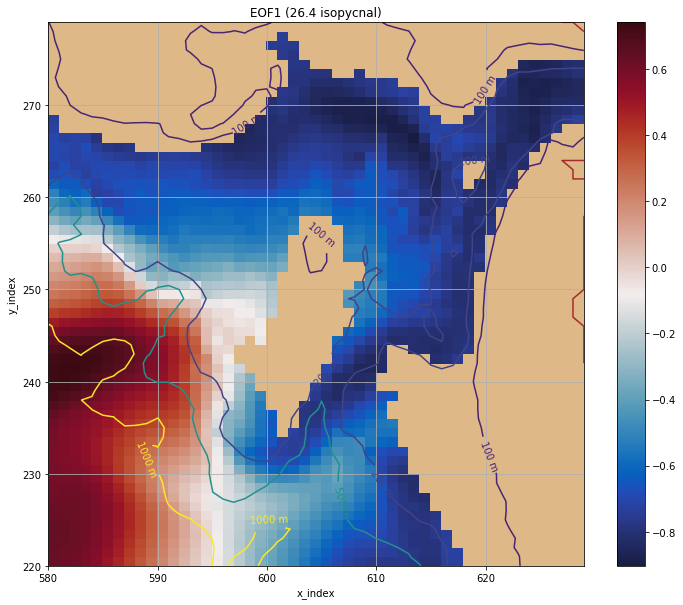

In [10]:
plot_isopycnal_eof_spice(0)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


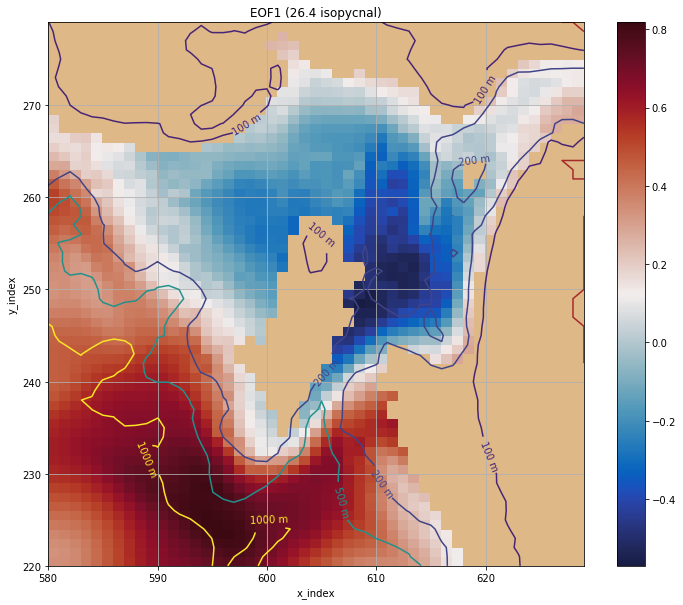

In [151]:
plot_isopycnal_eof_spice(1)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


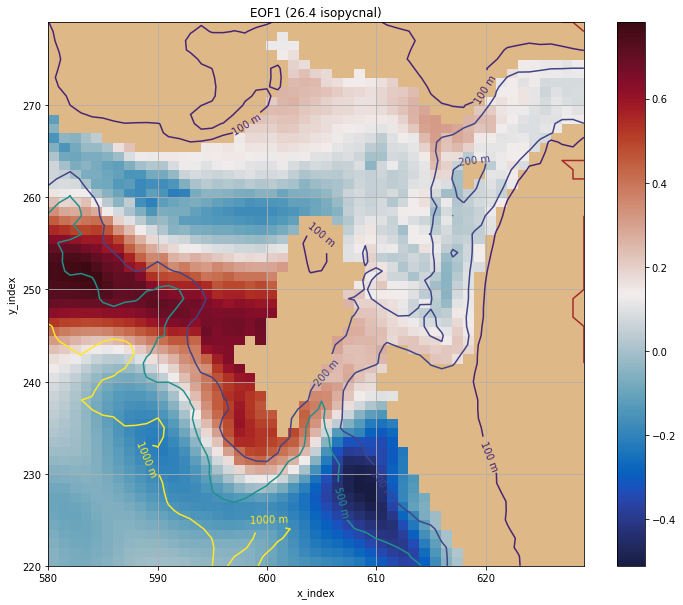

In [11]:
plot_isopycnal_eof_spice(2)

In [12]:


eigenValues = solver.eigenvalues()

anomaly_var = solver.totalAnomalyVariance()

percentContrib = eigenValues*100./np.sum(eigenValues)

In [18]:
print("The variance of the EOF1 is \u2248 {v:.2f}".format(v = percentContrib[0]))

print("The variance of the EOF2 is \u2248 {v:.2f}".format(v = percentContrib[1]))

print("The variance of the EOF3 is \u2248 {v:.2f}".format(v = percentContrib[2]))

The variance of the EOF1 is ≈ 35.24
The variance of the EOF2 is ≈ 17.59
The variance of the EOF3 is ≈ 10.24


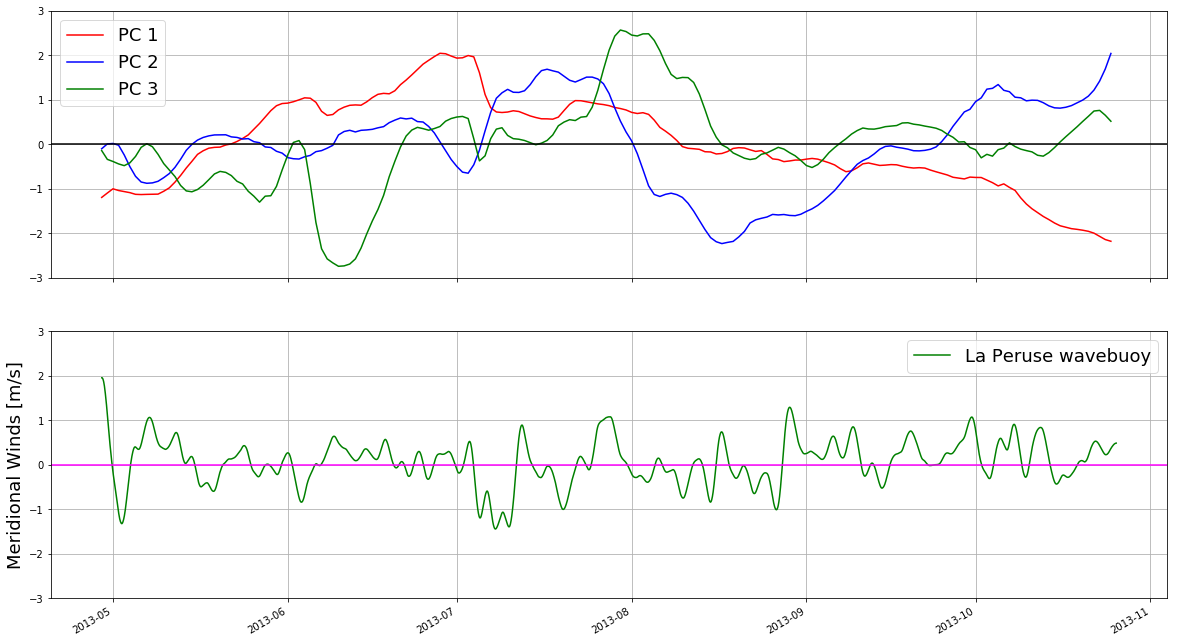

In [25]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,96,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u ,96,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,96,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12), sharex=True)
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



ax2.plot(time_axis, filt_v, 'g-', label = 'La Peruse wavebuoy')


# ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-3,3)
# plt.xticks(time_axis_quiver[::720], mydates[::30], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

fig.autofmt_xdate()


In [26]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)

time_axis = np.arange('2013-04-29T00:38', '2013-10-25T22:38', dtype='datetime64[h]')

In [27]:
time_axis.shape

(4318,)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


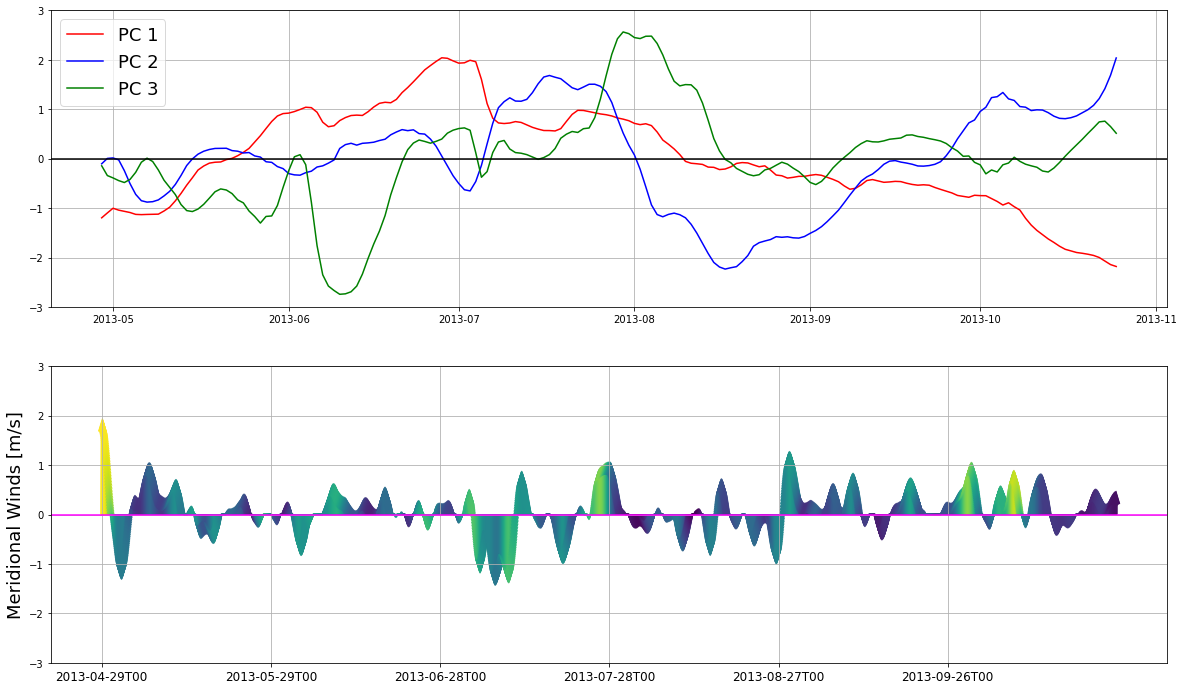

In [28]:
# time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,96,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,96,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,96,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12))
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



# ax2.plot(time_axis, filt_v, 'g-', label = 'La Peruse wavebuoy')

ax2.quiver(time_axis_quiver, 0, np.array(filt_u.astype(np.float64)), np.array(filt_v.astype(np.float64)), np.array(filt_wind.astype(np.float64)), angles='xy', scale_units='xy', scale=1)
# ax2.quiver(np.arange(filt_v.shape[0]), 0, filt_u, filt_v, filt_wind, angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-3,3)
plt.xticks(time_axis_quiver[::720], time_axis[::720], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

# fig.autofmt_xdate()

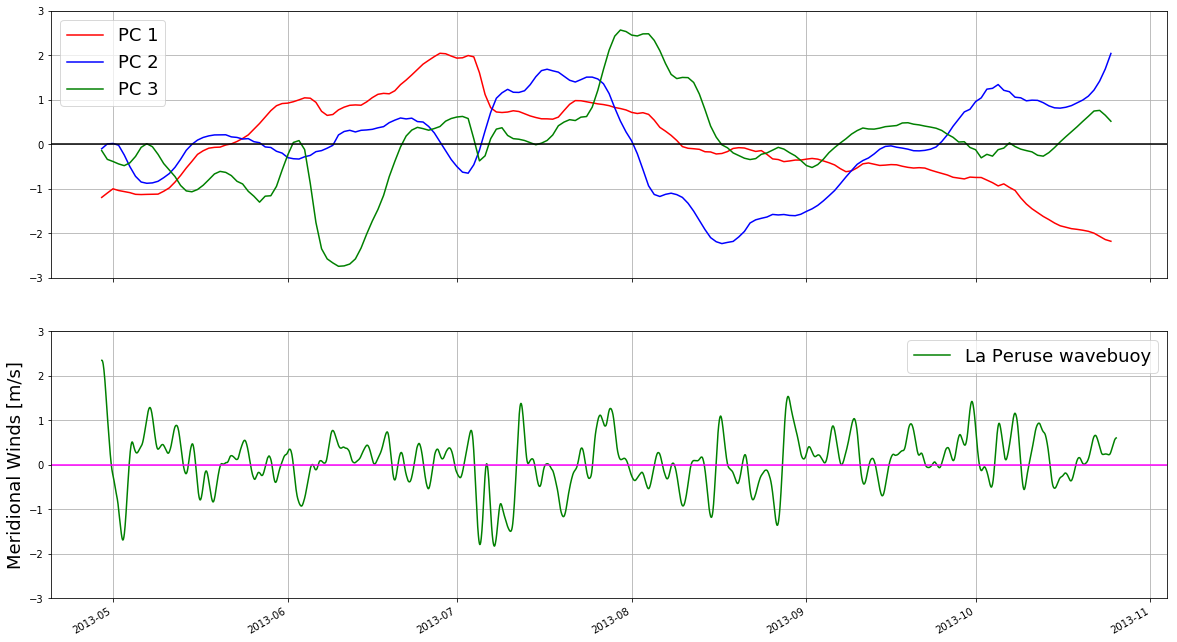

In [29]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,72,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,72,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,72,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12), sharex=True)
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



ax2.plot(time_axis, filt_v, 'g-', label = 'La Peruse wavebuoy')


# ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-3,3)
# plt.xticks(time_axis_quiver[::720], mydates[::30], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

fig.autofmt_xdate()


In [30]:
V = pd.Series(filt_v, index=time_axis)
daily_V = V.resample('1440T').sum()
V_wind = daily_V.values
V_wind_daily = np.divide(V_wind[:], 24)



# Speed_45 = np.sqrt(east_45**2 + north_45**2)

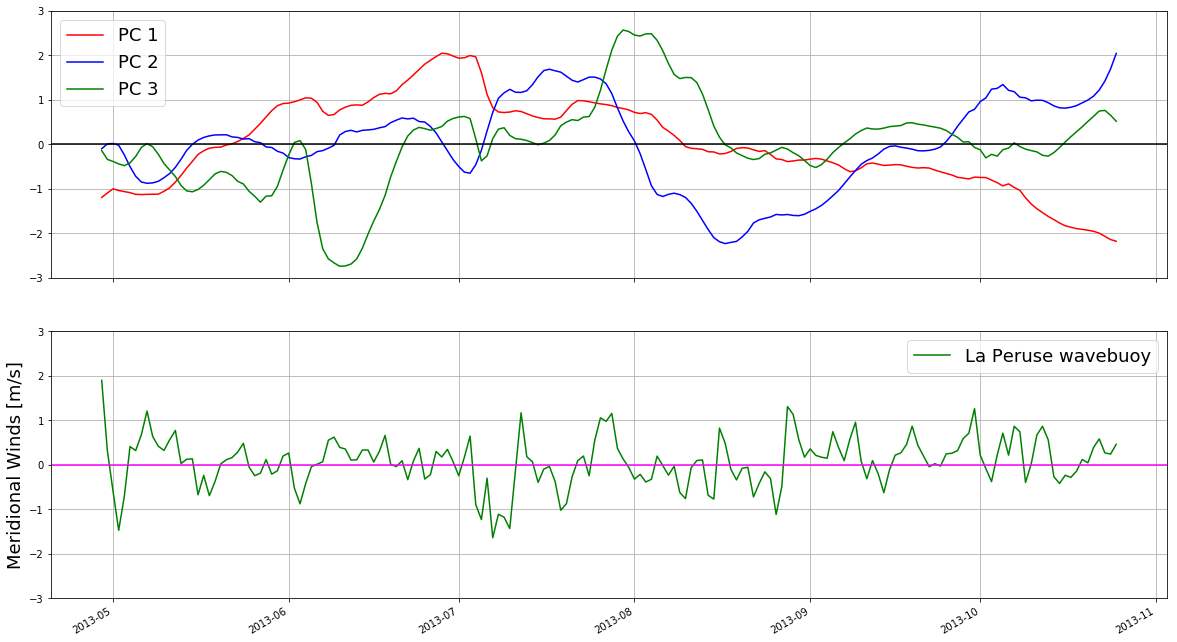

In [31]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,72,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,72,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,72,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12), sharex=True)
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



ax2.plot(mydates, V_wind_daily, 'g-', label = 'La Peruse wavebuoy')


# ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-3,3)
# plt.xticks(time_axis_quiver[::720], mydates[::30], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

fig.autofmt_xdate()


In [34]:
p = correlate(pcs[:,2], V_wind_daily)

In [40]:
np.max(p)

25.101002774594662

In [41]:
# LB08 Location Trace


lon_loc = -125.4775
lat_loc = 48.4217

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']

y_wcvi_slice = np.array(np.arange(220,280))
x_wcvi_slice = np.array(np.arange(580,630))


lon = bathy['nav_lon'][220:280, 580:630]
lat = bathy['nav_lat'][220:280, 580:630]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]

In [62]:
j, i = geo_tools.find_closest_model_point(lon_loc,lat_loc,\
                                          lon,lat,tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'\
                                          GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [49]:
print(j,i)

264 599


In [63]:
def plot_isopycnal_eof_spice(eof_number):
    

    val_iso = eofs[eof_number,...]
    val_iso[np.isnan(val_iso)] = 0
    val_iso = np.ma.masked_equal(val_iso, value=0)








    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


    Z = bathy.variables['Bathymetry']

#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(590,650))


    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]


    # cmap = plt.get_cmap('Blues')
    cmap = plt.get_cmap(cmo.cm.balance)


    cmap.set_bad('burlywood')
    fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()
    # p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=1000)
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels =[0, 100, 200, 500, 1000])
#     CS = ax.contour(x_wcvi_slice,y_wcvi_slice,depth_rho_0, levels =[0, 100, 200, 1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

    q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap)#, vmax = -1, vmin = 1)
    cbar = fig.colorbar(q, ax=ax)


    ax.scatter(x_wcvi_slice[i], y_wcvi_slice[j], c='orangered', s=100, alpha=0.6, label = 'LB08')
    
    ax.scatter(x_wcvi_slice[i], y_wcvi_slice[j-10], c='Cyan', s=100, alpha=0.6, label = 'Chosen Point')
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')
    ax.set_title('EOF1 (26.4 isopycnal)')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    # cbar = fig.colorbar(p, ax=ax)
    # cbar.ax.set_ylabel('Depth [m]', fontsize=20)
    ax.grid()


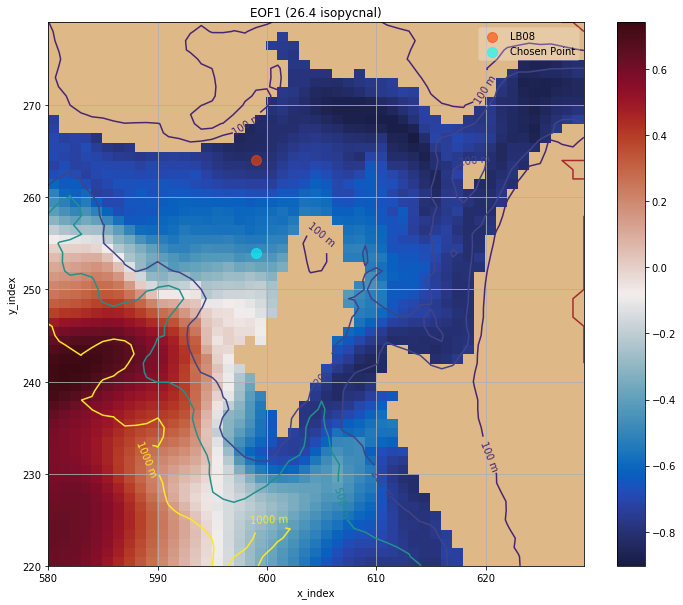

In [64]:
plot_isopycnal_eof_spice(0)

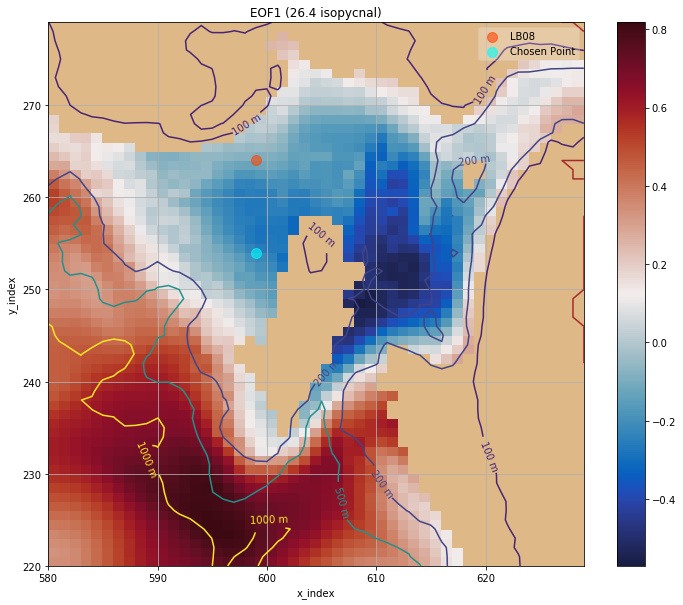

In [65]:
plot_isopycnal_eof_spice(1)

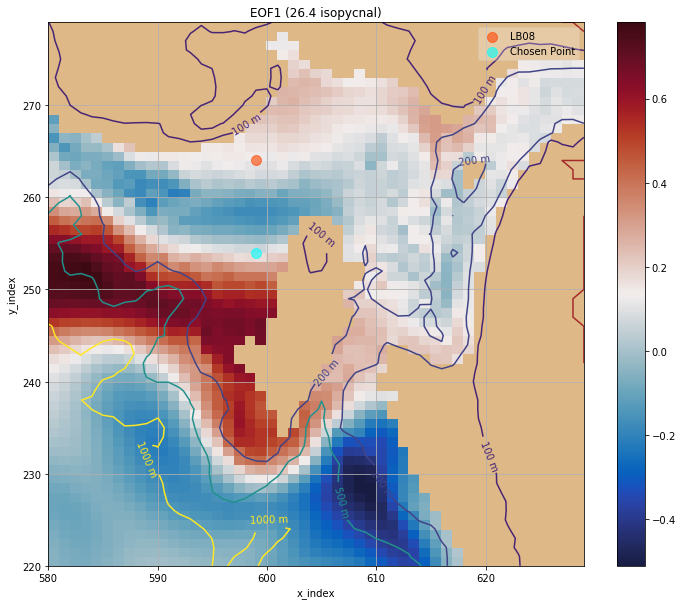

In [66]:
plot_isopycnal_eof_spice(2)

In [222]:
datetime_2013[1]

numpy.datetime64('2013-04-29T01:38')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


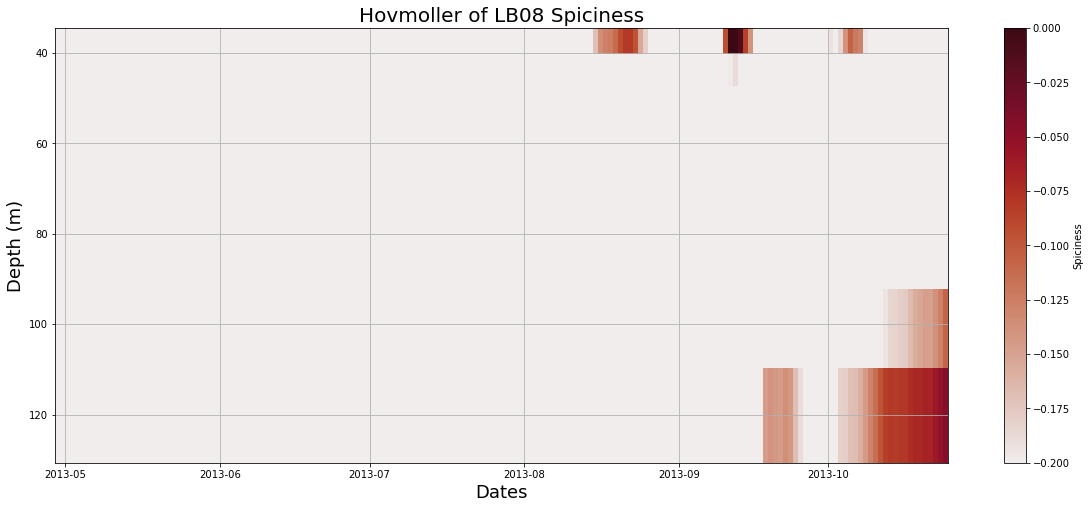

In [132]:
chosen_pt_hov = spic[:,:,j,i]

fig, ax = plt.subplots(1, 1, figsize=(20,8)); 




# viz_tools.set_aspect(ax)
cmap = plt.get_cmap(cmo.cm.amp)
cmap.set_bad('burlywood')
p = ax.pcolormesh(mydates, zlevels[15:24], np.transpose(chosen_pt_hov[:,15:24]), cmap=cmap, vmin=-0.2, vmax =0)#, vmax=500)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75)
ax.set_xlabel('Dates',fontsize=18)
ax.set_ylabel('Depth (m)',fontsize=18)

ax.set_title('Hovmoller of LB08 Spiciness', fontsize=20)
ax.invert_yaxis()

cbar = fig.colorbar(p, ax=ax, label='Spiciness')
ax.grid()

In [90]:
iso_spic.shape

(180, 7, 60, 50)

In [91]:
print(j,i)

44 19


In [89]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...][:,:,40:100,100:150]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [97]:
chosen_pt_hov[np.isnan(chosen_pt_hov)] = 0

chosen_pt_hov = np.ma.masked_equal(chosen_pt_hov, value=0)

In [110]:
chosen_pt_hov.shape

(180, 7)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


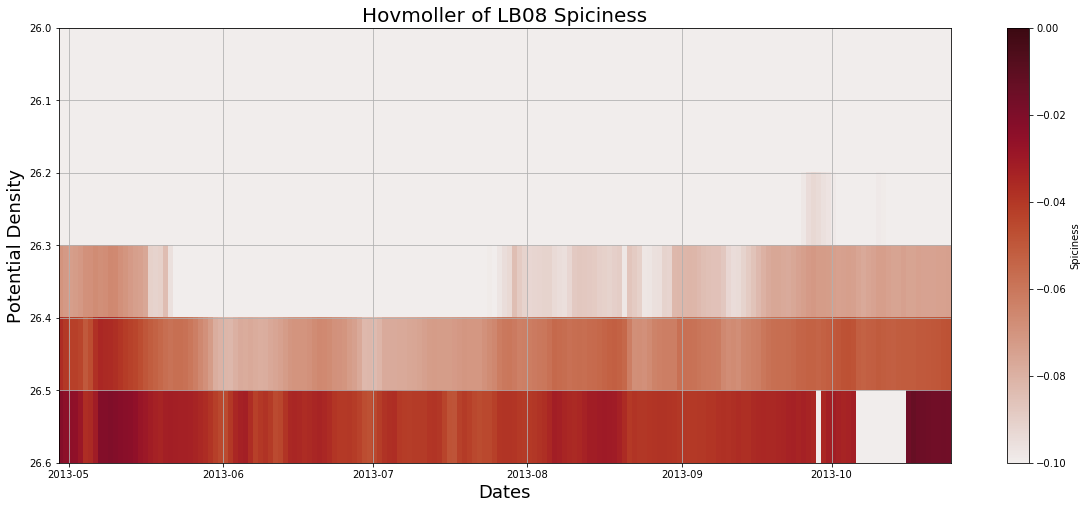

In [134]:
chosen_pt_hov = iso_spic[:,:,j,i]

fig, ax = plt.subplots(1, 1, figsize=(20,8)); 




# viz_tools.set_aspect(ax)
cmap = plt.get_cmap(cmo.cm.amp)
cmap.set_bad('burlywood')


p = ax.pcolormesh(mydates, isot[:], np.transpose(chosen_pt_hov[:,:]), cmap=cmap, vmin=-0.1, vmax =0)#, vmax=500)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75)
ax.set_xlabel('Dates',fontsize=18)
ax.set_ylabel('Potential Density',fontsize=18)

ax.set_title('Hovmoller of LB08 Spiciness', fontsize=20)
ax.invert_yaxis()

cbar = fig.colorbar(p, ax=ax, label='Spiciness')
ax.grid()

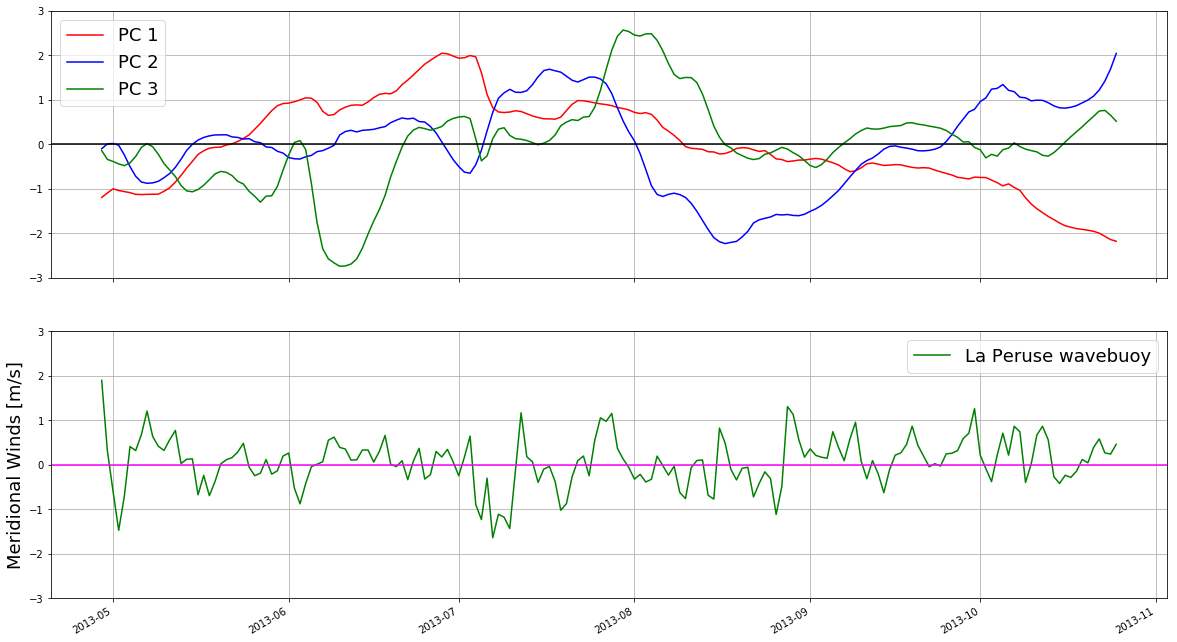

In [77]:
# u_quiver = np.array(u_wind[:].astype(np.float64))
# v_quiver = np.array(v_wind[:].astype(np.float64))
step = 1
# time_axis = np.arange(0,u_wind.shape[0],step)
time_axis = datetime_2013[::step]
# time_axis = timenp[::step]

# time_axis_quiver = np.arange(0,u_wind.shape[0],step)



s_v = v_wind[::step]   
filt_v = smooth(s_v,72,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,72,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,72,'hanning')
 
# Make plots
fig, (ax,ax2) = plt.subplots(2, 1, figsize=(20,12), sharex=True)
ax.plot(mydates,pcs[:,0] , 'r-', label = 'PC 1')  
ax.plot(mydates,pcs[:,1] , 'b-', label = 'PC 2')
ax.plot(mydates,pcs[:,2] , 'g-', label = 'PC 3')

ax.axhline(y=0, color='k')
ax.set_ylim(-3,3)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 



ax2.plot(mydates, V_wind_daily, 'g-', label = 'La Peruse wavebuoy')


# ax2.quiver(time_axis_quiver, 0, filt_u[::step], filt_v[::step], filt_wind[::step], angles='uv', scale_units='inches', scale=4)# , minshaft = 3)
#ax.plot(date_time[3600:6808], uwind_es[3600:6808], 'g-', label = 'LB08')

legend = ax2.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
#     ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax2.set_ylabel('Meridional Winds [m/s]', fontsize =18)
#ax.set_xticklabels(date_time[3600:6808])
ax2.set_ylim(-3,3)
# plt.xticks(time_axis_quiver[::720], mydates[::30], fontsize =12)
ax2.grid() 
ax2.axhline(y=0, color='magenta')

fig.autofmt_xdate()


The first EOF shows the eddy walls (spatial variability accounts for the strengthening of the eddy and thus the seasonal signal is expected to be captured here as the eddy strenghens through the summer); the second EOF shows the eddy structure and I guess that would show the eddy formation and source of water (confirm with Susan at the meeting); at first sight the second PCA looks to be correlated with the wind plot (look at the quiver plot at La Persue): so the question remains does it tell the story of entrainment (or is it achieved by the third EOF>> zero crossings of the third PCA)

Was the eddy even there in early May ? 

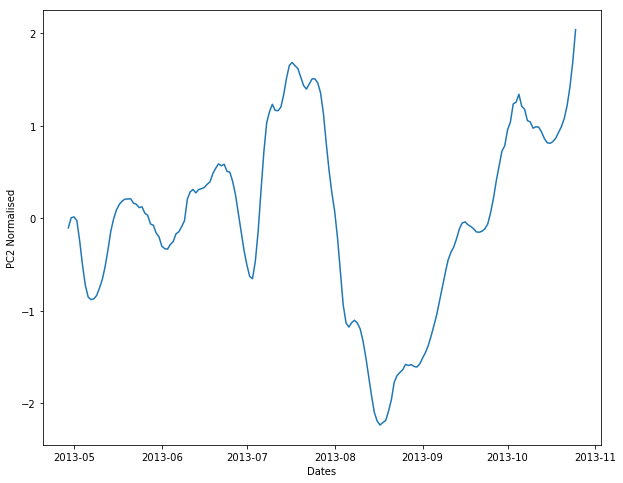

In [137]:
PC2 = pcs[:,1]

PC2_norm = PC2 - np.mean(PC2)



# let's plot the data
plt.figure(figsize = (10, 8))
plt.plot(mydates, PC2_norm)
plt.xlabel('Dates')
plt.ylabel('PC2 Normalised')



In [138]:
from matplotlib.mlab import find
def freq_zero_crossing(sig, fs):
    """
    Frequency estimation from zero crossing method
    sig - input signal
    fs - sampling rate
    
    return: 
    dominant period
    """
    # Find the indices where there's a crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))

    # Let's calculate the real crossings by interpolate
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    # Let's get the time between each crossing
    # the diff function will get how many samples between each crossing
    # we divide the sampling rate to get the time between them
    delta_t = np.diff(crossings) / fs
    
    # Get the mean value for the period
    period = np.mean(delta_t)
    
    return period

In [156]:
period_from_zero_crossing = freq_zero_crossing(PC2_norm, fs = 1)
print('The period estimation is %.1f days'%(period_from_zero_crossing))

The period estimation is 36.9 days


In [157]:


# get the frequency and spectrum
f, Pxx = sc.signal.periodogram(PC2_norm, fs = 1, window='hanning', scaling='spectrum')



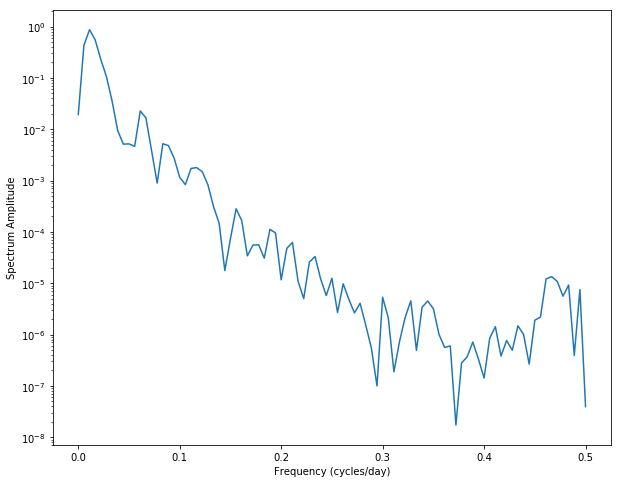

In [158]:
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.yscale('log')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Spectrum Amplitude')
# plt.xlim(0,1)

In [161]:


# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)



60.0
180.0
45.0
36.0
30.0


In [162]:
from statsmodels import api as sm

/home/ssahu/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [172]:


# get the autocorrelation coefficient
acf = sm.tsa.acf(PC2_norm, nlags=PC2_norm.shape[0])



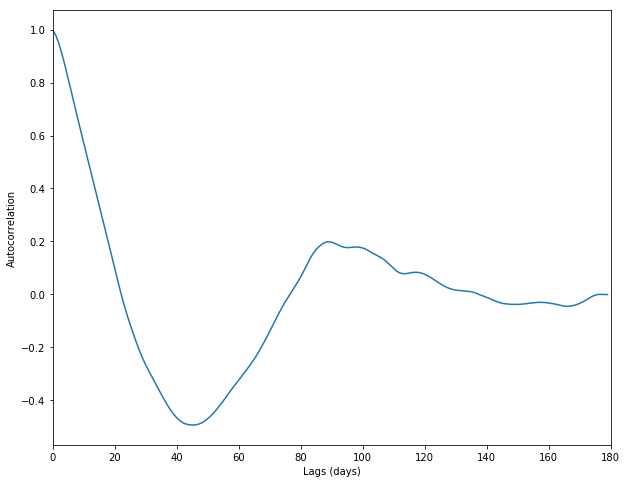

In [174]:
plt.figure(figsize = (10, 8))
lag = np.arange(PC2_norm.shape[0])
plt.plot(lag, acf)
plt.xlim((0, 180))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')

In [179]:
np.where(acf == np.max(acf[20:]))

(array([89]),)

The period of the second EOF mode is 90 days (approx)

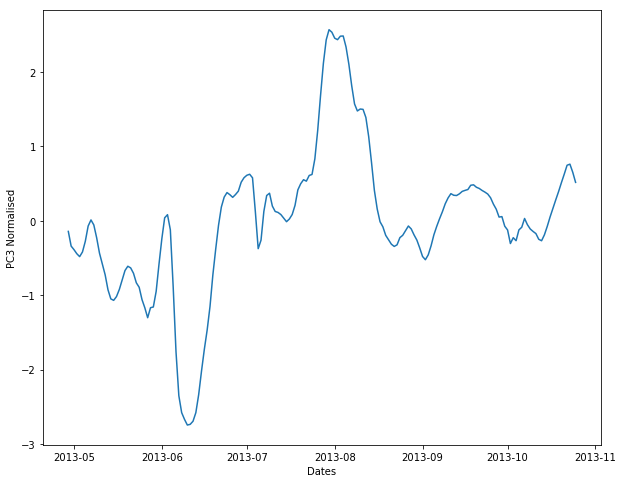

In [181]:
PC3 = pcs[:,2]

PC3_norm = PC3 - np.mean(PC3)



# let's plot the data
plt.figure(figsize = (10, 8))
plt.plot(mydates, PC3_norm)
plt.xlabel('Dates')
plt.ylabel('PC3 Normalised')



In [182]:
period_from_zero_crossing = freq_zero_crossing(PC3_norm, fs = 1)
print('The period estimation is %.1f days'%(period_from_zero_crossing))

The period estimation is 23.1 days


In [183]:


# get the frequency and spectrum
f, Pxx = sc.signal.periodogram(PC3_norm, fs = 1, window='hanning', scaling='spectrum')



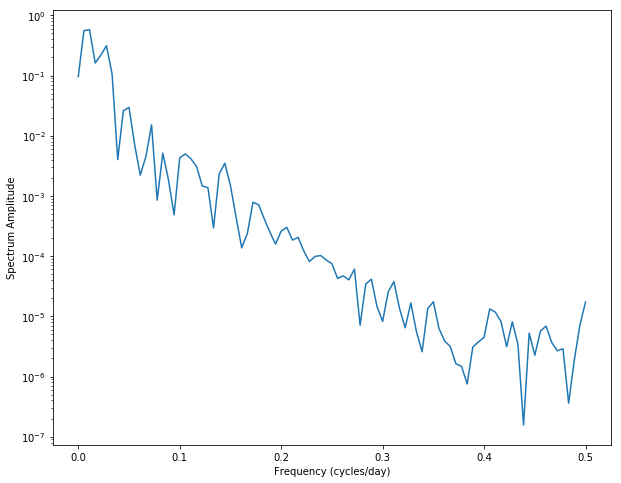

In [186]:
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.yscale('log')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Spectrum Amplitude')
# plt.xlim(0,1)

In [190]:


# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)



180.0
36.0
45.0
60.0
30.0


In [192]:


# get the autocorrelation coefficient
acf = sm.tsa.acf(PC3_norm, nlags=PC3_norm.shape[0])



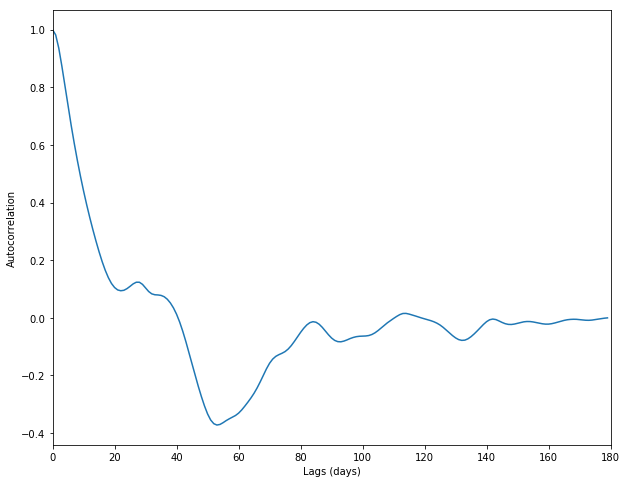

In [193]:
plt.figure(figsize = (10, 8))
lag = np.arange(PC3_norm.shape[0])
plt.plot(lag, acf)
plt.xlim((0, 180))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')